# Human Cortical Timescale: ECoG vs. Structural & Transcriptomic Measures
In this notebook, we look at synaptic fluctuation timescales in human cortex across the brain, and through aging, measured via iEEG and ECoG. 

We compare ECoG timescale maps with T1w/T2w map (surrogate for grey matter myelination, and thus, structural hierarchy), as well as postmortem human gene expression maps from the Allen Brain Atlas. All maps are projected onto the HCP-MMP parcellation (Glasser et al., 2016), but only the left side, for 180 parcels in total.

---

ECoG data is taken from the [MNI Open iEEG Atlas (e.g., Frauscher et al., 2018)](https://mni-open-ieegatlas.research.mcgill.ca/). It consists of 1772 channels from 106 patients (~20-65 years old) with varying coverages. The channels are a mixture of surface strip/grid electrodes and stereoEEG electrodes. ECoG electrode coordinates are originally provided in MNI coordinate, and we project them onto HCP-MMP with a simple Gaussian-weighted spatial average (done in ./analysis_collectDF, thanks to Thomas Pfeffer for code inspiration).

T1w/T2w and gene expression maps are very kindly provided by Rudy van den Brink (Tobias Donner lab) and Thomas Pfeffer (previously Donner lab, now Gustavo Deco lab).

All correlations are Spearman's rank correlation, and spatial correlation p-values are computed from resampled null-distributions (by shuffling).

---

### TL;DR:

Spatial correlation analyses follow the same style as Burt et al., 2018. Essentially, after all datasets are in the same spatial reference (HCP-MMP), we look at the rank correlation between timescale, and structural and gene expression variables. It's really quite surprising, but average ECoG timescale derived from 106 patients gathered from several hospitals significantly correlate with average gene expression and GM myelination from completely different cohorts of people, suggesting that it's a conserved property of the human brain. In addition, we see that average ECoG timescale decreases in older subjects, especially in sensorimotor and medial frontal areas.

In [43]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import matplotlib.pyplot as plt
import os, sys
import numpy as np
import pandas as pd
from scipy import io
from scipy.stats import spearmanr, ttest_1samp
from seaborn import despine
from sklearn import decomposition

sys.path.append('../')
import echo_utils

font = {'family' : 'Arial',
        'weight' : 'regular',
        'size'   : 14}
plt.rc('font', **font)
plt.rc('image', cmap='inferno')

C_ORD = plt.rcParams['axes.prop_cycle'].by_key()['color']
fig_path = '../figures/mni/%s.pdf'
save_plot=True

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
# load parcellation projected ECoG data & structural/transcriptomic data
d_query = 4
df_W_max = pd.read_csv('../data/df_human_W_max_%i.csv'%d_query, index_col=0)
df_tau_weighted = pd.read_csv('../data/df_human_tau_weighted_%i.csv'%d_query, index_col=0)
df_struct = pd.read_csv('../data/df_structural.csv', index_col=1)
df_ecog = pd.read_csv('../data/df_human.csv', index_col=0)
mmp_aggr = pd.read_csv('../data/mmp_macro.csv', index_col=0, names=['parcel','macro_region'])

# get patient info for age-related analysis
df_patient = df_ecog.groupby('patient').mean()[['gender', 'age']].astype(int)
df_patient.index = df_patient.index.astype(int)

# patient parcel coverage
w_thres = 0.5
df_patient.insert(len(df_patient.columns), 'coverage', np.sum(df_W_max>=w_thres,1))
df_patient.insert(len(df_patient.columns), 'pct_coverage', np.sum(df_W_max>=w_thres,1)/len(df_W_max.columns))

# compute thresholded and weighted average
df_tau_threshed = df_tau_weighted[df_W_max>=w_thres]
tau_parcel = echo_utils.compute_weighted_average(df_tau_weighted, df_W_max, w_thres, method='weighted')

# Patient Coverage in HCP Multi-Modal Parcellation
First we look at the electrode coverage of the entire dataset. Since spatial smoothing of the ECoG timescale is done with a Gaussian (of a defined width) and across the whole brain, all parcels in a single subject will have an interpolated value even if that person only has electrode coverage in one or two parcels.

We don't necessarily want to trust the interpolated value in PFC, for example, if it was smoothed over from the visual cortex. So we apply a threshold to include only parcels where the maximum Gaussian weight (confidence) is above a threshold (0.5 here), which means a parcel is only included for a subject if there was an electrode within some distance (4mm for the Gaussian I used for smoothing if threshold is 0.5).

colormap sequential: [0.00e+00, 1.40e+01, 2.80e+01] (opaque)


../echo_utils.py:367: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


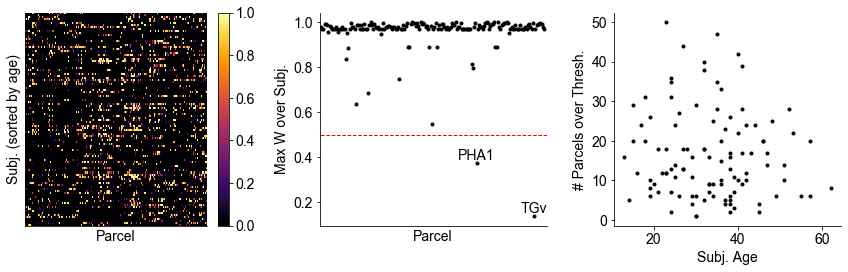

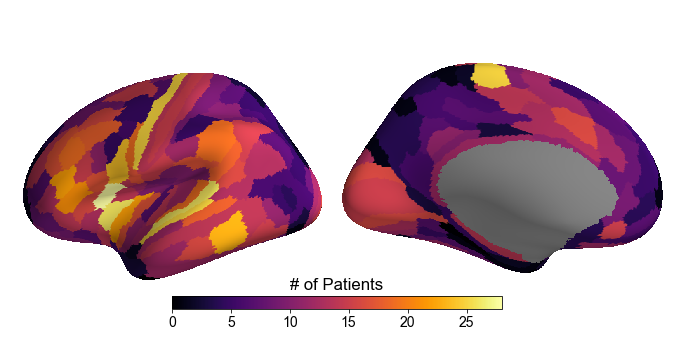

In [17]:
plot_subj_coverage = False
subj_fig_path = '../figures/mni/subj_mmp_coverage/'
if plot_subj_coverage:
    # plot aggregate max
    echo_utils.plot_MMP(np.max(df_W_max.values, axis=0), subj_fig_path+'aggregate')

    # plot individual subject map
    for s_i, s in df_W_max.iterrows():
        echo_utils.plot_MMP(s.values, subj_fig_path+'subj_%i'%int(s_i))

# --------
# visualization of thresholded coverage 
plt.figure(figsize=(12,4))

# heat map of weight matrix max (subj x parcel)
plt.subplot(1,3,1)
plt.imshow(df_W_max.values[np.argsort(df_patient['age']).values.astype(int),:], aspect='auto')
plt.xlabel('Parcel');plt.ylabel('Subj. (sorted by age)')
plt.xticks([]);plt.yticks([]); plt.colorbar()

# global maximum weight at each parcel, pooled over subjects
plt.subplot(1,3,2)
region_wmax = np.max(df_W_max.values,axis=0)
plt.plot(region_wmax, 'k.')
plt.plot(plt.xlim(),[w_thres, w_thres], 'r--', lw=1)
plt.xlim([-1,len(region_wmax)+1])
plt.xlabel('Parcel');plt.ylabel('Max W over Subj.')
plt.xticks([]); despine()
under_w_thresh = np.where(region_wmax<w_thres)[0]
for w in under_w_thresh:
    plt.text(w, region_wmax[w], df_W_max.columns[w], verticalalignment='bottom', horizontalalignment='center')


# of confident parcels per subject, sorted by age
plt.subplot(1,3,3)
plt.plot(df_patient['age'], df_patient['coverage'],'.k')
plt.xlabel('Subj. Age');plt.ylabel('# Parcels over Thresh.')
despine()
    
plt.tight_layout()
if save_plot: plt.savefig(fig_path%'mni_mmp_coverage')

# number of patients that had coverage at each parcel
parcel_cvg = (df_W_max>=w_thres).sum(axis=0)
plt.figure(figsize=(10,5))
echo_utils.plot_MMP(parcel_cvg, save_file=fig_path%'mmp_coverage', bp=2, title='# of Patients');

From the above, we see that coverage is quite sparse and idiosyncratic across patients (data matrix in first column). The full data matrix is around 10% populated, but pooling across subjects, most parcels have at least one patient with an electrode very close to it (weight value of >0.9). PHA1 and TGv are the only parcels that do not meet the threshold in even a single patient. The best coverage are in sensorimotor, temporal, and frontal regions (which makes sense for epilepsy localization). Temporal-occipital-parietal junction areas are also not bad, and visual regions are surprisingly well covered.

Also, a few subjects between 25-40 years old have coverages that are much more than normal (>30 parcels), but overall there doesn't seem to be a huge difference in coverage location (data matrix in first column) nor total coverage (third column) across age, which is important to check for the age analysis later on.

# Correlation between Timescale and Structural Measures
In the next set of analyses, we look at the parcel-wise correlation between grand average timescale, and structural heirarchy and also gene expression.

colormap sequential: [1.00e-02, 3.00e-02, 5.00e-02] (opaque)


../echo_utils.py:367: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


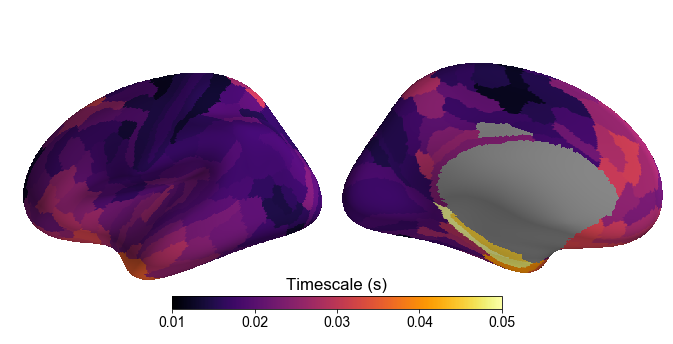

In [31]:
# plot grand average timescale on MMP
plt.figure(figsize=(10,5))
echo_utils.plot_MMP(tau_parcel, save_file=fig_path%'mmp_tau', minmax=[0.01,0.05], bp=2, title='Timescale (s)')

The above visualizes the spatial distribution of ECoG timescales projected onto HCP-MMP. 

Qualitatively, we see that timescale are shorter (faster) in sensory regions (sensorimotor, visual), while frontal (especial medial frontal) and medial temporal/hippocampal regions have longer timescales. 

This is consistent with reports in previous literature, where population timescales increase from sensory to association regions, but for the first time shown here for fast-timescale (synaptic fluctuation) dynamics across the whole human brain.

# Timescale vs. T1wT2w (Structural Hierarchy)

colormap sequential: [1.07e+00, 1.40e+00, 1.72e+00] (opaque)


../echo_utils.py:367: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


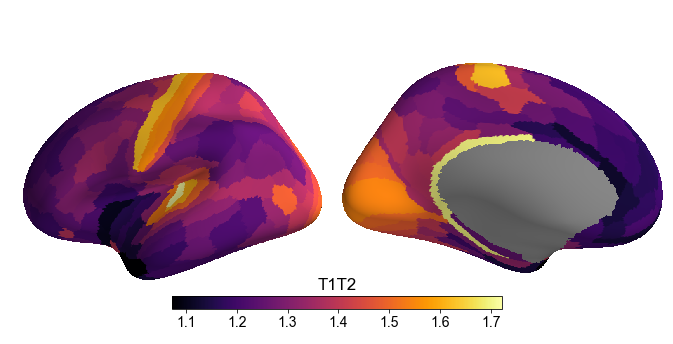

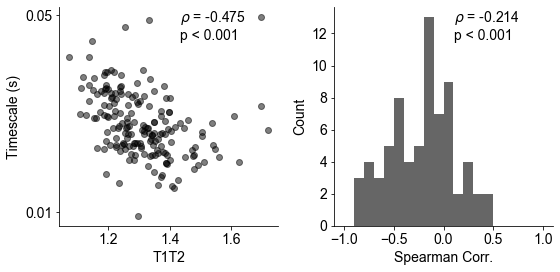

In [37]:
struct_feat = 'T1T2'

x = df_struct[struct_feat].values
y = tau_parcel

# plot feature on MMP brain
plt.figure(figsize=(10,5))
echo_utils.plot_MMP(x, save_file=fig_path%('mmp_'+struct_feat), bp=2, title=struct_feat)

# group average correlation
rho, pv = stats.spearmanr(df_struct[struct_feat], tau_parcel, nan_policy='omit')
rho, p_est, p_resamp, _ = echo_utils.perm_spearman(x, y, resamp='shuffle')

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.plot(x, y, 'ok', alpha=0.5); plt.yscale('log');
plt.xlabel(struct_feat); plt.ylabel('Timescale (s)'); despine()
plt.yticks([0.01, 0.05], ['0.01', '0.05']); plt.tick_params('y', which='minor', left=False, labelleft=False)
s = echo_utils.sig_str(rho, p_resamp, form='text')
plt.annotate(s, xy=(0.55, 0.85), xycoords='axes fraction')

# per-subject correlation
min_parcels = 10
df_subj_corr = pd.DataFrame(index=df_tau_weighted.index, columns=['n_parcels', 'rho', 'pv'])
for i_s, subj in df_tau_threshed.iterrows():
    df_subj_corr['n_parcels'].loc[i_s] = (~np.isnan(subj)).sum()
    if df_subj_corr['n_parcels'].loc[i_s]>=3:
        rho, pv = spearmanr(x, subj, nan_policy='omit')
    else:
        rho, pv = np.nan, np.nan
    df_subj_corr['rho'].loc[i_s],df_subj_corr['pv'].loc[i_s] = rho,pv

# only count correlations from subjects that had min # of parcels
corr_valid = df_subj_corr[df_subj_corr['n_parcels']>=min_parcels]['rho'].values.astype(float)
tt_pv = ttest_1samp(corr_valid, 0)[1]
plt.subplot(1,2,2)
plt.hist(corr_valid, bins=np.arange(-1,1.1,0.1), color='k', alpha=0.6)
plt.xlabel('Spearman Corr.');plt.ylabel('Count');despine()
s = echo_utils.sig_str(np.nanmean(corr_valid), tt_pv, form='text', corr_letter=r'mean $\rho$')
plt.annotate(s, xy=(0.55, 0.85), xycoords='axes fraction')

plt.tight_layout();
plt.savefig(fig_path[:-4]%('mmp_tau_%s_%i'%(struct_feat,d_query)), bbox_inches='tight')

T1T2 ratio is a measure of gray matter myelination, and has been shown (Burt et al., 2018) to be higher in sensory regions (converging long-range connections) than association regions (local recurrent connections).

Overall, ECoG timescale is significantly and negatively correlated with T1wT2w measurements. This is true on average and at the individual subject level (only subjects with at least min_parcel number of parcels are included). This means areas with higher T1T2 values (higher myelination) have shorter timescales, again suggesting shorter timescale dynamics in primary sensory regions. There are exceptions, however, such as the lone dot in the top right corner, and the neighborhood of datapoints to the middle right (high T1T2, intermediate timescale).

We can also look at this correlation within each subject. Since coverage varies between patients, we set a threshold where a subject is included only if they have at least n number of parcels (10 here). Again, correlations are significantly negative (2-sided 1-sample t-test) but with exceptions.

__In summary, fast synaptic fluctuation timescales measured via human ECoG is significantly correlated with, and may index, anatomical hierarchy, which itself is an index of feedforward vs. recurrent dominant architecture.__

# Timescale vs. Gene Expression

,ADRA1A,ADRA1B,ADRA1D,ADRA2A,ADRA2B,ADRA2C,ADRB1,ADRB2,ADRB3,DRD1,...,GABRG1,GABRG2,GABRG3,GABRP,GABRQ,GABRR1,GABRR3,VIP,PV+,SOM
0,0.04213,0.120457,-0.079871,-0.054109,0.076692,0.139509,-0.15086,0.162431,0.027826,-0.071737,...,0.125183,-0.155292,-0.130295,-0.00176,0.156415,0.05023,-0.001857,0.002188,-0.165883,0.16765


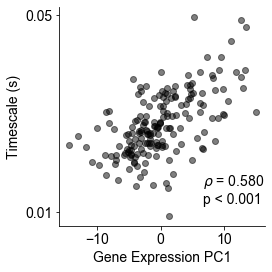

In [53]:
# perform PCA on all genes
gene_pca = decomposition.PCA(10)
gene_pca.fit(np.array(df_struct)[:,2:])
gene_grad = gene_pca.fit_transform(np.array(df_struct)[:,2:])

x = gene_grad[:,0]
y = tau_parcel.values
rho, _, p_resamp, _ = echo_utils.perm_spearman(x, y, 1000, 'shuffle')

plt.figure(figsize=(4,4))
plt.plot(x, y, 'ok', alpha=0.5); plt.yscale('log')
plt.xlabel('Gene Expression PC1'); plt.ylabel('Timescale (s)'); despine()
plt.yticks([0.01, 0.05], ['0.01', '0.05']); plt.tick_params('y', which='minor', left=False, labelleft=False)
plt.annotate(echo_utils.sig_str(rho, p_resamp, form='text'), xy=(0.7,0.1), xycoords='axes fraction');
plt.tight_layout();
plt.savefig(fig_path[:-4]%('mmp_tau_genePC1_%i'%d_query), bbox_inches='tight')

# what are the genes that contribute the most to PC1
# pd.DataFrame(gene_pca.components_[0,:], index=df_struct.columns[2:]).T

Following Burt et al., 2018, we look at the (synaptic) gene expression gradient across the cortex altogether via PCA, and compare that with ECoG timescale. The full list of genes can be found in the data table in ../df_structural.csv, and they are the common glutamate and GABA, as well as neuromodulatory synaptic genes, as well as inhibitory cell type (PV, SOM, VIP).

We can see above that timescale is significantly correlated with the dominant gene expression gradient (1st principal component), even more so than with anatomical hierarchy, suggesting a synaptic basis/support for the measured ECoG timescale. Extracellular voltage fluctuations measured via LFP and ECoG are predominantly caused by transmembrane currents, whose timescale depend both on the neuronal integration and synaptic time constants. As such, expression of synapses with longer time constants should coincide with longer ECoG timescale.

In [63]:
# compute correlation of timescale with individual genes
df_tau_corr_all = pd.DataFrame(index=df_struct.columns[1:], columns=['rho', 'pv'])
for i_f, s_f in enumerate(df_struct.columns[1:]):
    rho, _, p_resamp, _ = echo_utils.perm_spearman(df_struct[s_f], tau_parcel.values)    
    df_tau_corr_all.loc[s_f] = rho, p_resamp
    
color = plt.cm.RdBu_r(np.linspace(0,1,200))

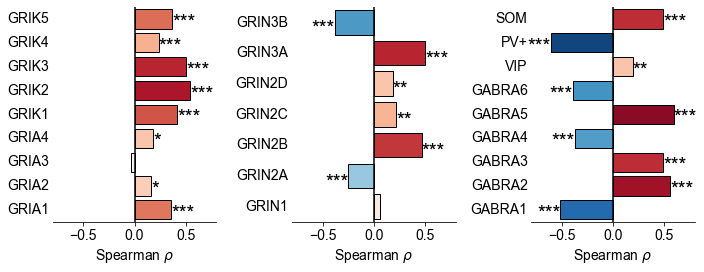

In [64]:
# select a list of genes of interest
expr_ampa = df_tau_corr_all.index[45:49].values
expr_nmda = df_tau_corr_all.index[49:56].values
expr_kainate = df_tau_corr_all.index[66:71].values
expr_gaba = df_tau_corr_all.index[71:77].values
expr_inh = df_tau_corr_all.index[89:92].values

gene_sets = [np.concatenate((expr_ampa, expr_kainate)), expr_nmda, np.concatenate((expr_gaba, expr_inh))]
plt.figure(figsize=(10,4))
for i_g, query_set in enumerate(gene_sets):
    plt.subplot(1,3, i_g+1)
    for i_f, s_f in enumerate(query_set):
        rho, pv = df_tau_corr_all.loc[s_f]
        plt.barh(i_f, rho, ec='k', fc=color[int((1+rho*1.5)*100)])
        s = np.sum(pv<=np.array([0.05, 0.01, 0.005]))*'*'
        plt.text(rho, i_f-0.4, s, fontsize=20, horizontalalignment='left' if rho>0 else 'right')

    plt.plot([0,0], plt.ylim(), 'k')
    plt.ylim([-0.5,len(query_set)-0.5])
    plt.yticks(range(len(query_set)), query_set, rotation=0, ha='right', va='center', rotation_mode='anchor')
    plt.tick_params(axis='y', which=u'both',length=0)
    plt.xlim([-.8,.8]); plt.xlabel(r'Spearman $\rho$')
    despine(left=True);
    

plt.tight_layout()
plt.savefig(fig_path%'mni_gene_indiv',  bbox_inches='tight')

A quick note on this synaptic receptor subunits: synaptic receptors are composed of several subunits, which have isoforms that can be swapped in and out, modulating different aspects of synapse function. For example, "NMDA receptor channels are heterotetramers composed of two molecules of the key receptor subunit NMDAR1 (GRIN1) and two drawn from one or more of the four NMDAR2 subunits: NMDAR2A (GRIN2A), NMDAR2B (GRIN2B), NMDAR2C (GRIN2C), and NMDAR2D (GRIN2D)" (per [Wikipedia](https://en.wikipedia.org/wiki/GRIN2B)).

From the plots above, ECoG timescale is positively and strongly correlated with expression of kainate (GRIK), and less so with AMPA (GRIA) receptor subunits (left plot). AMPA receptors are everywhere in the brain and have very fast rise and decay time constants, so it makes sense for them to be less spatially correlated with ECoG timescales.

Correlation with NMDA subunits expression is more variable: most strongly with GRIN2B, which has been shown to lengthen NMDA activation time constant and improve cognitive function in animals with engineered overexpression. 

In addition, timescales are also strongly correlated with the expression of various forms of GABA receptor alpha subunit, as well as inhibitory cell type markers. Interestingly, timescale is strongly and negatively correlated with PV expression, and positively correlated with SOM expression.

__In summary, fast synaptic fluctuation timescales are also strongly correlated with average gene expression of many synaptic receptor proteins, linking dynamics with its potential structural support. __

---
# Age-related Changes in Tau

### Median Age Split

Ttest_1sampResult(statistic=-0.8319861889407119, pvalue=0.4066645449111732)
colormap sequential: [-2.00e-02, 0.00e+00, 2.00e-02] (opaque)


/Users/rdgao/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:1999: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


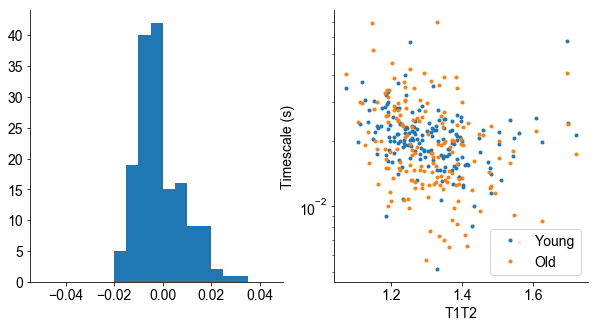

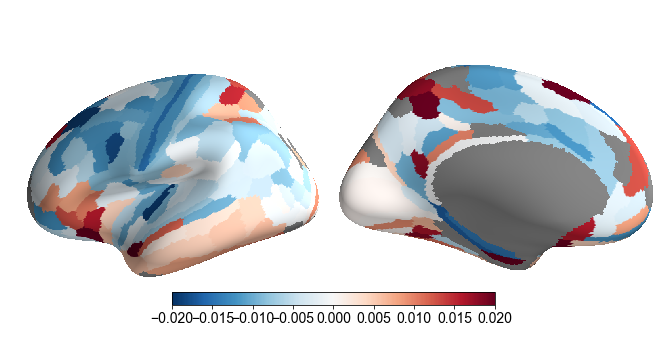

In [135]:
inds_young = df_patient['age']<df_patient['age'].median()
inds_old = df_patient['age']>=df_patient['age'].median()

tau_parcel_age = []
for inds in [inds_young, inds_old]:
    tau_parcel_age.append(compute_weighted_average(df_tau_weighted[inds], df_W_max[inds], w_thres, method='thresh_weighted'))

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
tau_diff = (tau_parcel_age[1]-tau_parcel_age[0]).values
plt.hist(tau_diff[~np.isnan(tau_diff)], np.arange(-0.05,0.05,0.005))
print(stats.ttest_1samp(tau_diff, 0, nan_policy='omit'))

plt.subplot(1,2,2)
plt.plot(df_struct[struct_feat], tau_parcel_age[0], '.', label='Young')
plt.plot(df_struct[struct_feat], tau_parcel_age[1], '.', label='Old')
plt.yscale('log'); plt.legend()
plt.xlabel(struct_feat);plt.ylabel('Timescale (s)'); despine()

plt.figure(figsize=(10,5))
echo_utils.plot_MMP(tau_diff, save_file=fig_path%'mmp_taudiff_oldyoung', minmax=[-0.02,0.02], bp=2, cmap='RdBu_r')

# Age vs. Timescale 
### per-subject average, over all parcels

The ideal analysis to do here is mixed effects model to separately estimate the effect of age and region on tau, but the overall coverage of the data is very poor (10% of total subj x parcel matrix is non-nan), and coverage is vastly different across subjects. 

Averaging across subjects for the per-parcel estimate is not too bad, since each parcel has a relatively even sampling of age ranges, and we expect a rather large spatial effect in the first place. But averaging across parcels for the per-subject estimate is very biased by the non-uniform coverage of each patient, so we need to normalize each tau by the parcel average (or max) first before averaging across parcels to remove the spatial effect. Kinda janky, but best I can think of given the sparse sampling.

I set a threshold on how many parcels the subject needs to have to be included in this analysis in the first place. Doesn't have to be a large value, since each person usually only has 5-20% coverage (10-30 out of 180).

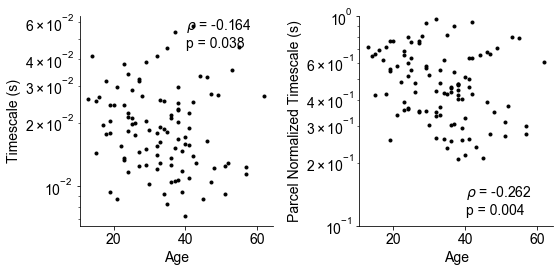

In [276]:
n_parcel_thresh = 3

plt.figure(figsize=(8,4))

# unnormalized averages over parcels per patient
plt.subplot(1,2,1)
tau_subj = compute_weighted_average(df_tau_weighted, df_W_max, w_thres, method='weighted', axis=1)
x = df_patient['age'][df_patient['coverage']>=n_parcel_thresh]
y = tau_subj[df_patient['coverage']>=n_parcel_thresh]
rho, pv_est, pv, _ = echo_utils.perm_spearman(x,y,1000)
plt.semilogy(x, y, '.k');
plt.xlabel('Age'); plt.ylabel('Timescale (s)'); despine()
s = echo_utils.sig_str(rho, pv, form='^')
plt.annotate(s, xy=(0.55, 0.85), xycoords='axes fraction')

# normalized averages over parcels per patient
plt.subplot(1,2,2)
df_tau_threshed_parcelnorm = df_tau_threshed/df_tau_threshed.max()
tau_subj_normed = df_tau_threshed_parcelnorm.mean(axis=1)
y = tau_subj_normed[df_patient['coverage']>=n_parcel_thresh]
plt.semilogy(x, y, '.k')
plt.xlabel('Age'); plt.ylabel('Parcel Normalized Timescale (s)'); despine()
rho, pv = spearmanr(x, y)
rho, pv_est, pv, _ = echo_utils.perm_spearman(x,y,1000)
s = echo_utils.sig_str(rho, pv, form='^')
plt.ylim([0.1, 1])
plt.annotate(s, xy=(0.55, 0.05), xycoords='axes fraction')
plt.tight_layout()


# Age-Tau correlation per parcel
We can also look at the age-tau correlation for each individual parcel and see the overall trend across parcels, as well as location-dependent correlation.

colormap sequential: [-7.50e-01, 0.00e+00, 7.50e-01] (opaque)


../echo_utils.py:367: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  if save_file:


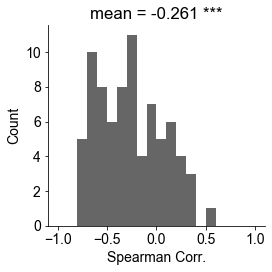

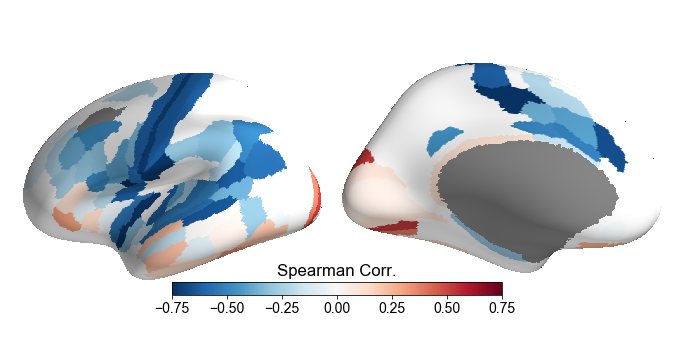

In [280]:
# minimum number of subjects that passed threshold in a parcel to include parcel
min_subjs = 10
df_age_corr=pd.DataFrame(index=df_tau_weighted.columns, columns=['n_subjs', 'rho', 'pv'])
for parcel, col in df_tau_threshed.iteritems():
    df_age_corr['n_subjs'].loc[parcel] = (~np.isnan(col)).sum()
    if df_age_corr['n_subjs'].loc[parcel]>=3:
        rho, pv = stats.spearmanr(df_patient['age'], col, nan_policy='omit')
        df_age_corr['rho'].loc[parcel], df_age_corr['pv'].loc[parcel] = rho, pv
    else:
        df_age_corr['rho'].loc[parcel], df_age_corr['pv'].loc[parcel] = np.nan, np.nan
        
# only count correlations from parcels that had min # of subjs
parcel_corr = df_age_corr['rho']
parcel_corr[df_age_corr['n_subjs']<=min_subjs]=np.nan

plt.figure(figsize=(4,4))
plt.hist(parcel_corr.values.astype(float), bins=np.arange(-1,1.1,0.1), color='k', alpha=0.6)
tt_pv = stats.ttest_1samp(parcel_corr.values.astype(float), 0, nan_policy='omit')[1]
plt.xlabel('Spearman Corr.');plt.ylabel('Count');despine()
s = 'mean = %.3f '%np.nanmean(parcel_corr.values) + np.sum(tt_pv<=np.array([0.05, 0.01, 0.005]))*'*'
plt.title(s);
plt.tight_layout()
plt.savefig(fig_path[:-4]%('mmp_parcel_agecorr_dist_%i'%(d_query)), bbox_inches='tight')

parcel_corr[df_age_corr['n_subjs']<=min_subjs]=0
plt.figure(figsize=(10,5))
echo_utils.plot_MMP(parcel_corr.values, fig_path%'mmp_parcel_agecorr', minmax=[-.75,.75], cmap='RdBu_r')
plt.title('Spearman Corr.');

SpearmanrResult(correlation=-0.1534930480502618, pvalue=0.17969542782750234)

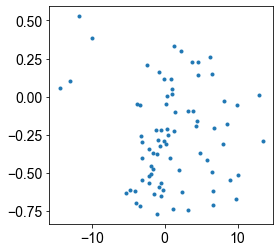

In [281]:
# tau-age correlation per parcel vs. structural measures
plt.figure(figsize=(4,4))
#plt.plot(gene_grad[:,0], parcel_corr.values!=0, '.')
plt.plot(gene_grad[parcel_corr.values!=0,0], parcel_corr.values[parcel_corr.values!=0], '.')
spearmanr(df_struct['PV+'].values[parcel_corr.values!=0], parcel_corr.values[parcel_corr.values!=0])

# parcel normalized tau vs. age

In [197]:
1-np.isnan(df_tau_threshed).sum(0)/df_tau_threshed.shape[0]
1-np.isnan(df_tau_threshed).sum(1)/df_tau_threshed.shape[1]
np.isnan(df_tau_threshed).sum().sum()/np.prod(df_tau_threshed.shape)

0.9084905660377358

### By Glasser Macro Regions (21)

In [109]:
# aggregating by macro region
df_tau_macro = pd.DataFrame(columns=np.unique(mmp_aggr['macro_region']))
df_struct_macro = pd.DataFrame(columns=np.unique(mmp_aggr['macro_region']))
for i_r, r in mmp_aggr.groupby('macro_region'):
    df_tau_macro[i_r] = compute_weighted_average(df_tau_weighted[r['parcel']], df_W_max[r['parcel']], axis=1, method='thresh_weighted')
    df_struct_macro[i_r] = df_struct.loc[r['parcel']].mean(axis=0)
    
df_struct_macro = df_struct_macro.T
df_tau_macro_mean = df_tau_macro.mean(0)

['dlpfc' 'ifc' 'mpfc_acc' 'ofc']


SpearmanrResult(correlation=-0.2335185688272608, pvalue=0.07254335481257278)

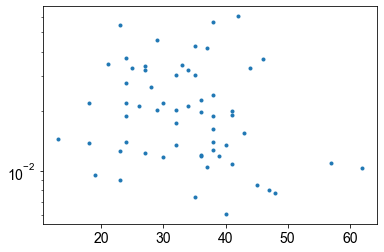

In [110]:
print(np.unique(mmp_aggr['macro_region'])[[2,3,8,9]])
frontal_regions = np.unique(mmp_aggr['macro_region'])[[2,3,8,9]]
frontal_inds = []
for reg in frontal_regions:
    frontal_inds.append(mmp_aggr[(mmp_aggr['macro_region']==reg)].index.values)

frontal_inds = np.sort(np.hstack(frontal_inds))
tau_frontal = compute_weighted_average(df_tau_weighted[mmp_aggr.loc[frontal_inds]['parcel']], 
                                       df_W_max[mmp_aggr.loc[frontal_inds]['parcel']], 
                                       axis=1, method='thresh_weighted').values

plt.plot(df_patient['age'], tau_frontal, '.')
plt.yscale('log')
stats.spearmanr(df_patient['age'], tau_frontal, nan_policy='omit')




SpearmanrResult(correlation=-0.6402597402597403, pvalue=0.001769793050350851)

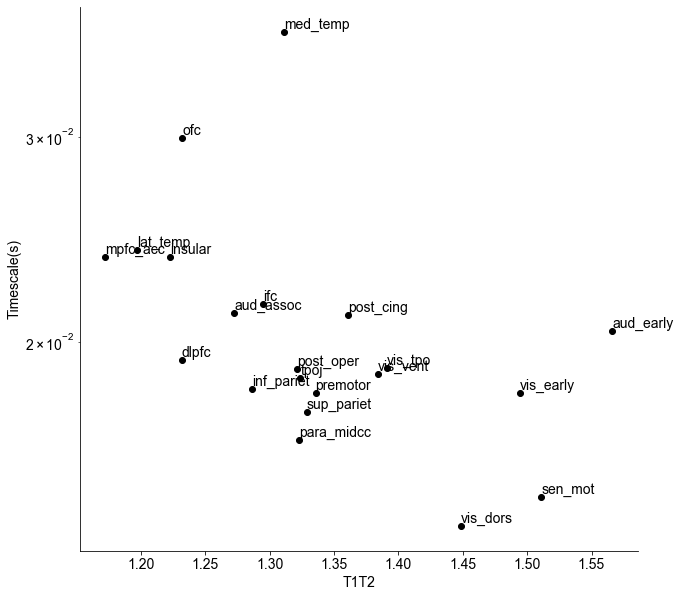

In [176]:
# macro-region level correlation
struct_feat = 'T1T2'
plt.figure(figsize=(10,10))
plt.plot(df_struct_macro[struct_feat],df_tau_macro_mean, 'ok')
for mr in df_struct_macro.index:
    plt.annotate(mr, (df_struct_macro.loc[mr][struct_feat], df_tau_macro_mean[mr]), 
                 horizontalalignment='left', verticalalignment='bottom')
    
plt.yscale('log'); 
plt.xlabel(struct_feat); plt.ylabel('Timescale(s)');despine()
stats.spearmanr(df_struct_macro[struct_feat],df_tau_macro.mean(0), nan_policy='omit')

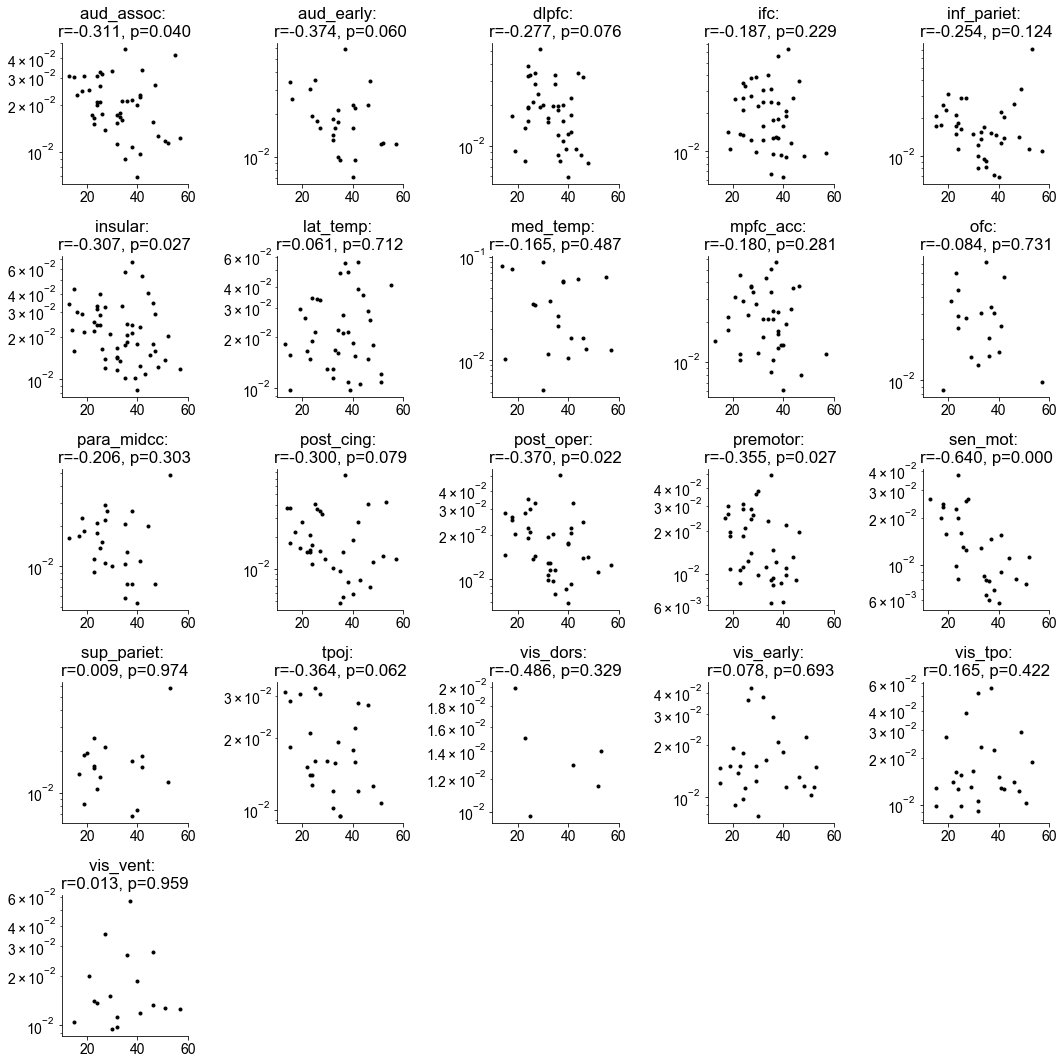

In [112]:
# age correlation
plt.figure(figsize=(15,15))
for i_r, r in enumerate(df_tau_macro.columns):
    plt.subplot(5,5,i_r+1)
    plt.plot(df_patient['age'], df_tau_macro[r], '.k')
    rho,pv = stats.spearmanr(df_patient['age'], df_tau_macro[r], nan_policy='omit')
    plt.yscale('log')
    plt.xlim([10,60]); despine()
    plt.tick_params(axis='y', which='both', left='off', labelleft='off')
    plt.title('%s: \nr=%.3f, p=%.3f'%(r,rho,pv))

plt.tight_layout()

### By Quantiles of T1T2 (Cortical Hierarchy)

colormap sequential: [0.00e+00, 1.50e+00, 3.00e+00] (opaque)


../echo_utils.py:367: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  if save_file:
/Users/rdgao/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


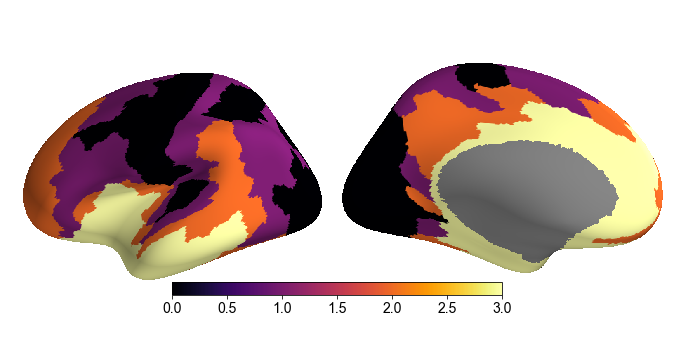

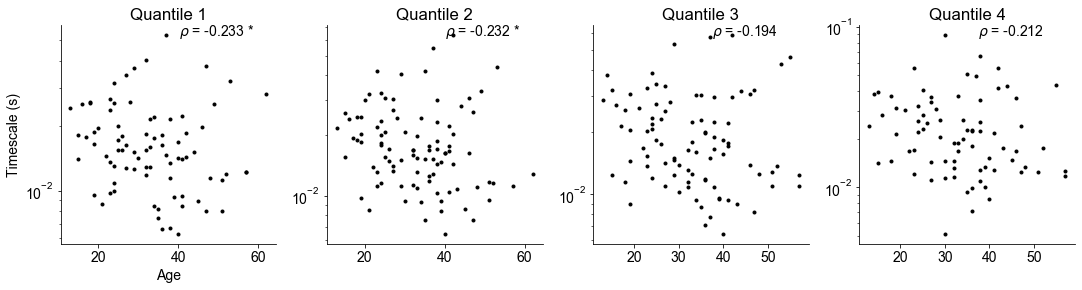

In [117]:
# label the parcels based on quantile of T1T2 value
quants = 4
struct_feat = 'PV+'
parcels_quant = quants-np.digitize(df_struct[struct_feat], np.quantile(df_struct[struct_feat], np.arange(0,1,1/quants)))
plt.figure(figsize=(10,5))
echo_utils.plot_MMP(parcels_quant, fig_path[:-4]%('mmp_'+struct_feat+'_quantile'))

plt.figure(figsize=(15,4))
for quant in range(quants):
    plt.subplot(1,quants,quant+1)
    # weighted sum
    tau_avg = compute_weighted_average(df_tau_weighted.T[parcels_quant==quant], df_W_max.T[parcels_quant==quant], w_thres, method='thresh_weighted')

    rho, pv = stats.spearmanr(df_patient['age'], tau_avg, nan_policy='omit')
    plt.plot(df_patient['age'], tau_avg, 'k.')
    s = r'$\rho$ = %.3f '%rho + np.sum(pv<=np.array([0.05, 0.01, 0.001]))*'*'
    plt.annotate(s, xy=xy_axis_frac, xycoords='axes fraction')
    plt.yscale('log'); despine()
    plt.title('Quantile %i'%(quant+1))

plt.tight_layout()
plt.subplot(1,quants,1); plt.xlabel('Age'); plt.ylabel('Timescale (s)')
plt.savefig(fig_path[:-4]%('mmp_tau_age_quantile%i'%(d_query)), bbox_inches='tight')


### Group by age

In [296]:
age_bins = np.arange(20,70,10)
df_tau_age_grp = pd.DataFrame(index=age_bins, columns=df_tau_weighted.columns)
age_grp = np.digitize(df_patient.age.values, age_bins[:-1])
df_patient['age_group']=age_grp
for age, group in df_patient.groupby('age_group'):
    df_tau_age_grp.loc[age_bins[age]] = compute_weighted_average(df_tau_weighted.loc[group.index], df_W_max.loc[group.index], w_thres, method='thresh_weighted')

df_tau_age_grp


,V1,MST,V6,V2,V3,V4,V8,4,3b,FEF,...,p47r,TGv,MBelt,LBelt,A4,STSva,TE1m,PI,a32pr,p24
20,0.0146072,0.0126074,NaN,0.0139693,0.0139735,NaN,NaN,0.0216812,0.0217871,0.0246265,...,0.011351,NaN,0.0323788,0.031566,0.0259861,0.0338098,0.0307168,0.0249202,0.0289377,NaN
30,0.0126562,0.0109717,NaN,0.0180221,0.01233,0.0173693,NaN,0.019259,0.0211493,0.0179652,...,0.0278832,NaN,0.0237848,0.0251886,0.0203748,0.0263922,0.0243563,0.0224703,0.0411189,0.0372159
40,0.0275825,NaN,NaN,0.0347686,0.018971,0.0280518,0.0081573,0.00790446,0.00937638,0.00827379,...,0.0296098,NaN,0.0136168,0.0226066,0.0177721,0.0208562,0.0190956,0.0231447,0.0302651,0.0369148
50,0.0150091,0.0123987,NaN,0.0166994,0.0208196,0.0153812,0.0119134,0.0102782,0.0115341,NaN,...,0.0361083,NaN,0.0188427,0.0229293,0.0167192,0.0198327,0.0305416,0.0153103,0.0232156,0.0120466
60,0.0173325,NaN,0.0115528,0.0188035,0.0260086,0.0325026,NaN,0.00766021,0.0075667,NaN,...,0.00966893,NaN,0.0130565,0.0124724,0.010809,0.0376447,0.01103,0.0140653,0.0113643,NaN


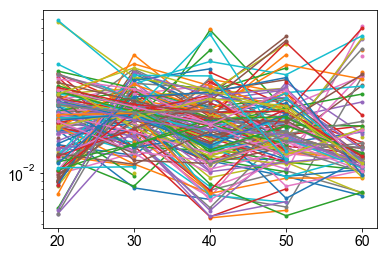

In [370]:
plt.plot(df_tau_age_grp, '.-');
plt.yscale('log')
rho=[]
for reg, col in df_tau_age_grp.iteritems():
    rho.append(stats.spearmanr(col, age_bins)[0])

rho=np.array(rho)

# correlation tau t1t2 per person and plot as function of age
# multiple regression predicting per-parcel tau-age rho with t1t2 & gene
# parcelwise normalized timescale average per subject vs age